In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn import model_selection, preprocessing
import xgboost as xgb


import seaborn as sns
color = sns.color_palette()
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

houses_train = pd.read_csv("C:/Users/ML/Downloads/Houses/all/train.csv")
houses_test = pd.read_csv("C:/Users/ML/Downloads/Houses/all/test.csv")

np.random.seed(0) 

In [3]:
print(houses_train.columns)
print(houses_train.shape)
print(houses_test.shape)

Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', 'price_doc'],
      dtype='object', length=292)
(30471, 292)
(7662, 291)


In [4]:
houses_train.head()


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64


C:\Users\ML\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


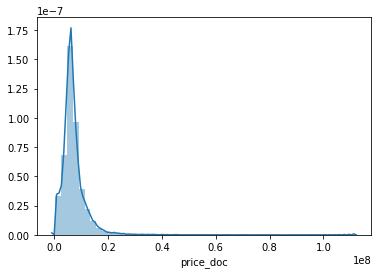

In [6]:
print(houses_train['price_doc'].describe())
sns.distplot(houses_train['price_doc'])

In [6]:
missing_values_count = houses_train.isnull().sum()
missing_values_count[0:10]

id                0
timestamp         0
full_sq           0
life_sq        6383
floor           167
max_floor      9572
material       9572
build_year    13605
num_room       9572
kitch_sq       9572
dtype: int64

In [7]:
total_cells = np.product(houses_train.shape)
total_missing = missing_values_count.sum()

(total_missing/total_cells) * 100

2.9336899265998704

In [8]:
# remove all the rows that contain a missing value on num_room
rows_with_na_dropped = houses_train.num_room.dropna()
inst_with_num_room = rows_with_na_dropped.index.tolist()
train1 = pd.DataFrame(data = houses_train.loc[np.squeeze(inst_with_num_room)])
print(len(inst_with_num_room))

20899


In [10]:
#correcting life_sq data
conditions = [(train1['life_sq'].isna()), (train1['life_sq']>train1['full_sq'])]
choices = [train1['full_sq'], train1['full_sq']]
train1['life_sq_mod'] = np.select(conditions, choices, default=train1['life_sq'])

In [11]:
#correcting floor data
conditions = [(train1['floor']>train1['max_floor'])]
choices = [train1['max_floor']]
train1['floor_mod'] = np.select(conditions, choices, default=train1['floor'])

In [12]:
#correcting build_year data
conditions = [(train1['build_year']>2018), (train1['build_year']<1900)]
choices = [np.nan, np.nan]
train1['build_year_mod'] = np.select(conditions, choices, default=train1['build_year'])

In [13]:
#correcting kitch_sq data
conditions = [(train1['kitch_sq']>train1['life_sq_mod'])]
choices = [np.nan]
train1['kitch_sq_mod'] = np.select(conditions, choices, default=train1['kitch_sq'])

In [14]:
# remove all the columns that contain a missing value on kitch_sq_mod
valid_kitch = train1.kitch_sq_mod.dropna()
inst_with_kitch_sq = valid_kitch.index.tolist()
train2 = pd.DataFrame(data = train1.loc[np.squeeze(inst_with_kitch_sq)])
print(len(inst_with_kitch_sq))
print(train2.shape[0])

20843
20843


In [15]:
# remove all the columns that contain a missing value on build_year_mod
valid_build_year = train2.build_year_mod.dropna()
inst_with_build_year = valid_build_year.index.tolist()
train3 = pd.DataFrame(data = train2.loc[np.squeeze(inst_with_build_year)])
print(len(inst_with_build_year))
print(train3.shape[0])

15904
15904


In [16]:
total_cells = np.product(train3.shape)
missing_values_count = train3.isnull().sum()
total_missing = missing_values_count.sum()
(total_missing/total_cells) * 100

1.25495370873892

In [17]:
# remove all the columns that contain a missing value and with unnessesary data and rename  modified columns' names 
train4 = train3.dropna(axis=1)
train5 = train4.drop(['timestamp', 'floor', 'build_year', 'kitch_sq'], axis=1)
train5 = train5.rename(index=str, columns={"life_sq_mod":"life_sq","floor_mod":"floor", "build_year_mod":"build_year", "kitch_sq_mod":"kitch_sq"})

In [18]:
missing_values_count = train5.isnull().sum()
missing_values_count.index[1:6]

missing_values_count

id                                       0
full_sq                                  0
max_floor                                0
material                                 0
num_room                                 0
product_type                             0
sub_area                                 0
area_m                                   0
raion_popul                              0
green_zone_part                          0
indust_part                              0
children_preschool                       0
preschool_education_centers_raion        0
children_school                          0
school_education_centers_raion           0
school_education_centers_top_20_raion    0
healthcare_centers_raion                 0
university_top_20_raion                  0
sport_objects_raion                      0
additional_education_raion               0
culture_objects_top_25                   0
culture_objects_top_25_raion             0
shopping_centers_raion                   0
office_raio

count    15904.000000
mean        15.688510
std          0.634693
min         11.512926
25%         15.483217
50%         15.739759
75%         16.034714
max         18.370676
Name: LogAmt, dtype: float64


C:\Users\ML\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


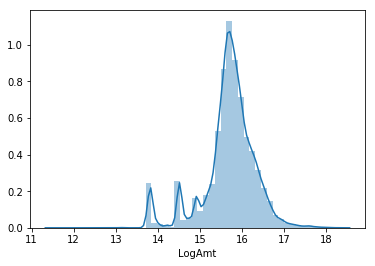

In [19]:
train5['LogAmt']=np.log(train5.price_doc+0.005)
print(train5['LogAmt'].describe())
sns.distplot(train5['LogAmt'])

In [20]:
train5.to_csv('clean_dataset.csv')

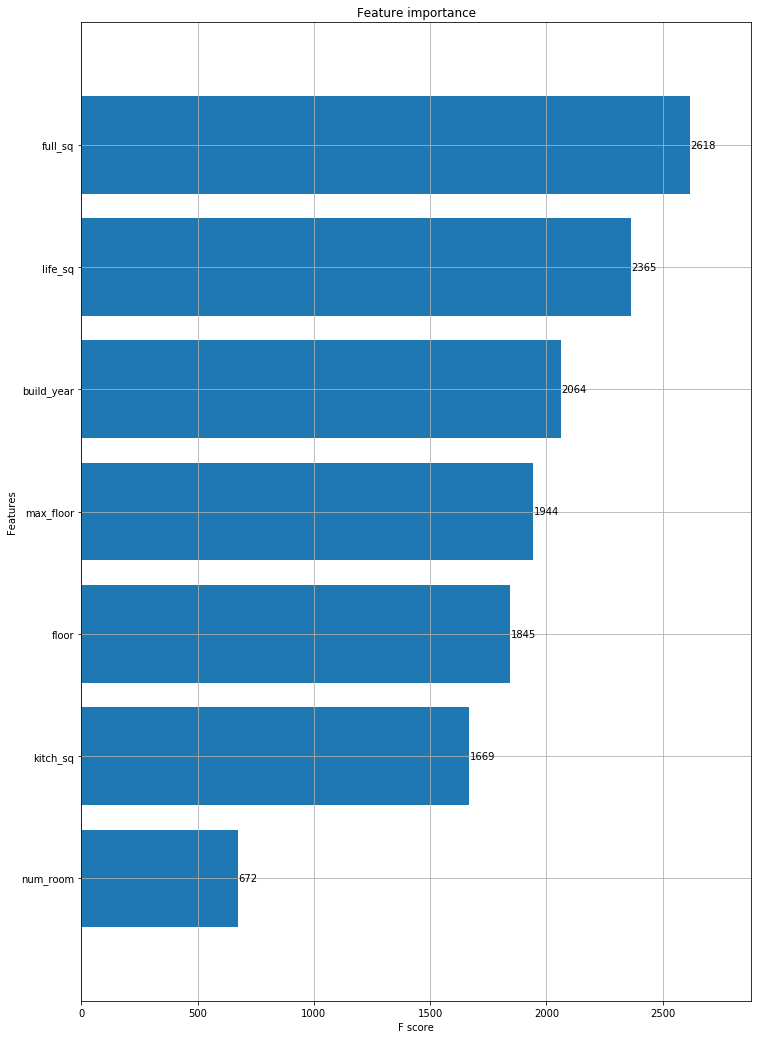

In [30]:
from sklearn.model_selection import train_test_split

for f in train5.columns:
    if train5[f].dtype=='object':       
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train5[f].values)) 
        train5[f] = lbl.transform(list(train5[f].values))
        
y = train5.price_doc.values
X = train5[["full_sq", "life_sq", "num_room", "kitch_sq", "build_year", "floor", "max_floor"]]

# split data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)


xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
model.save_model('house_price')

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [33]:
# houses_test = houses_test[["full_sq", "life_sq", "num_room", "kitch_sq", "build_year", "floor", "max_floor", "price_doc"]]
# houses_test = houses_test.dropna()
# test_X = houses_test[["full_sq", "life_sq", "num_room", "kitch_sq", "build_year", "floor", "max_floor"]]
# test_y = houses_test.price_doc.values

dtest = xgb.DMatrix(X_val, feature_names=X_val.columns.values)
y_pred = model.predict(dtest)

In [39]:
# evaluate predictions
from sklearn.metrics import mean_squared_error
from math import sqrt

MSE = mean_squared_error(y_val, y_pred)
print("RMSE: %.2f" % sqrt(MSE))

RMSE: 3286289.64


In [ ]:
# ulimit = np.percentile(houses_train.price_doc.values, 99.5)
# llimit = np.percentile(houses_train.price_doc.values, 0.5)
# houses_train['price_doc'].ix[houses_train['price_doc']>ulimit] = ulimit
# houses_train['price_doc'].ix[houses_train['price_doc']<llimit] = llimit

# col = "full_sq"
# ulimit = np.percentile(houses_train[col].values, 99.5)
# llimit = np.percentile(houses_train[col].values, 0.5)
# houses_train[col].ix[houses_train[col]>ulimit] = ulimit
# houses_train[col].ix[houses_train[col]<llimit] = llimit

# plt.figure(figsize=(12,12))
# sns.jointplot(x=np.log1p(houses_train.full_sq.values), y=np.log1p(houses_train.price_doc.values), size=10)
# plt.ylabel('Log of Price', fontsize=12)
# plt.xlabel('Log of Total area in square metre', fontsize=12)
# plt.show()

TO DO: pipeline with simple XGboost and linear regresion